In [4]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [71]:
from optuna.samplers import TPESampler
import optuna
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from tqdm import tqdm
# min max scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from utils.util_functions import import_data, calculate_mase2
from sklearn import preprocessing
from utils.group_ts_split import GroupTimeSeriesSplit, PurgedGroupTimeSeriesSplit
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor
from ngboost.distns import Normal

In [46]:
df_train = import_data('data/extra_train_morelags.csv')
# drop brackets from column names
df_train.columns = df_train.columns.str.replace('[', '', regex=False)
df_train.columns = df_train.columns.str.replace(']', '', regex=False)
df_train.columns = df_train.columns.str.replace(' ', '_', regex=False)
df_train

Memory usage of dataframe is 18.31 MB
Memory usage after optimization is: 4.70 MB
Decreased by 74.3%


,Month,Hour,cons_target,Solar_Generation_W/kW,Outdoor_Drybulb_Temperature_C,Relative_Humidity_%,Diffuse_Solar_Radiation_W/m2,Direct_Solar_Radiation_W/m2,day_year,number,...,net_target-26,net_target-27,net_target-28,net_target-29,net_target-30,net_target_diff,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8,7,0.156494,14.093750,18.906250,90.0,2.773438,2.708984,30,1,...,0.437744,0.382324,0.382080,0.383301,0.506836,0.019974,4.761719,3.761719,87.0,20.000000
1,8,8,0.143188,109.625000,20.000000,87.0,4.761719,3.761719,31,1,...,0.418457,0.437744,0.382324,0.382080,0.383301,-0.042175,5.535156,4.316406,87.0,20.000000
2,8,9,0.147095,269.500000,20.000000,87.0,5.535156,4.316406,32,1,...,0.466553,0.418457,0.437744,0.382324,0.382080,-0.052582,5.679688,3.583984,84.0,20.000000
3,8,10,0.129395,447.000000,20.000000,84.0,5.679688,3.583984,33,1,...,0.341064,0.466553,0.418457,0.437744,0.382324,-0.073547,6.078125,4.562500,76.0,21.703125
4,8,11,0.077026,594.000000,21.703125,76.0,6.078125,4.562500,34,1,...,0.267334,0.341064,0.466553,0.418457,0.437744,-0.086792,6.406250,5.347656,73.0,21.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43640,7,19,0.802734,31.171875,21.093750,81.0,5.390625,5.667969,8754,5,...,0.763184,0.653320,0.482666,0.505371,0.358643,0.090393,3.294922,4.875000,84.0,20.593750
43641,7,20,0.552734,4.070312,20.593750,84.0,3.294922,4.875000,8755,5,...,0.797363,0.763184,0.653320,0.482666,0.505371,-0.141235,0.000000,0.000000,81.0,21.093750
43642,7,21,0.189453,0.000000,21.093750,81.0,0.000000,0.000000,8756,5,...,0.812012,0.797363,0.763184,0.653320,0.482666,-0.223145,0.000000,0.000000,79.0,21.703125
43643,7,22,0.436279,0.000000,21.703125,79.0,0.000000,0.000000,8757,5,...,0.814941,0.812012,0.797363,0.763184,0.653320,0.152954,0.000000,0.000000,76.0,21.296875


In [64]:
df_test = import_data('data/extra_test_morelags.csv')
# drop brackets from column names
df_test.columns = df_test.columns.str.replace('[', '', regex=False)
df_test.columns = df_test.columns.str.replace(']', '', regex=False)
df_test.columns = df_test.columns.str.replace(' ', '_', regex=False)

Memory usage of dataframe is 3.66 MB
Memory usage after optimization is: 0.94 MB
Decreased by 74.3%


In [65]:
X = df_train.drop(['number', 'net', 'day_year'], axis=1)
# for j in range(1,25):
#     X = X.drop([f'net+{j}', f'net_target+{j}', f'net-{j-1}'], axis=1)
X_temp = X.drop(['net+1', 'net_target+1', 'net-23', 'Solar_Generation_W/kW',
       'Outdoor_Drybulb_Temperature_C', 'Relative_Humidity_%',
       'Diffuse_Solar_Radiation_W/m2', 'Direct_Solar_Radiation_W/m2', 'cons_target'], axis=1)
df_test = df_test.drop(['number', 'net', 'day_year'], axis=1)
X_test = df_test.drop(['net+1', 'net_target+1', 'net-23', 'Solar_Generation_W/kW',
         'Outdoor_Drybulb_Temperature_C', 'Relative_Humidity_%',
            'Diffuse_Solar_Radiation_W/m2', 'Direct_Solar_Radiation_W/m2', 'cons_target'], axis=1)
y_test = df_test['net_target+1']
# 'net_target_diff',
features = X_temp.columns
categoricals = []
print(categoricals)
y = df_train['net_target+1']
groups = df_train['day_year'].values
X_temp

[]


,Month,Hour,hour_x,hour_y,month_x,month_y,net_target,net_target-1,net_target-2,net_target-3,...,net_target-26,net_target-27,net_target-28,net_target-29,net_target-30,net_target_diff,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8,7,-0.258789,0.965820,-0.500000,-0.866211,0.417236,0.397217,0.388428,0.389648,...,0.437744,0.382324,0.382080,0.383301,0.506836,0.019974,4.761719,3.761719,87.0,20.000000
1,8,8,-0.500000,0.866211,-0.500000,-0.866211,0.375000,0.417236,0.397217,0.388428,...,0.418457,0.437744,0.382324,0.382080,0.383301,-0.042175,5.535156,4.316406,87.0,20.000000
2,8,9,-0.707031,0.707031,-0.500000,-0.866211,0.322266,0.375000,0.417236,0.397217,...,0.466553,0.418457,0.437744,0.382324,0.382080,-0.052582,5.679688,3.583984,84.0,20.000000
3,8,10,-0.866211,0.500000,-0.500000,-0.866211,0.248779,0.322266,0.375000,0.417236,...,0.341064,0.466553,0.418457,0.437744,0.382324,-0.073547,6.078125,4.562500,76.0,21.703125
4,8,11,-0.965820,0.258789,-0.500000,-0.866211,0.161987,0.248779,0.322266,0.375000,...,0.267334,0.341064,0.466553,0.418457,0.437744,-0.086792,6.406250,5.347656,73.0,21.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43640,7,19,0.258789,-0.965820,-0.866211,-0.500000,0.862305,0.771973,0.588867,0.526855,...,0.763184,0.653320,0.482666,0.505371,0.358643,0.090393,3.294922,4.875000,84.0,20.593750
43641,7,20,0.500000,-0.866211,-0.866211,-0.500000,0.720703,0.862305,0.771973,0.588867,...,0.797363,0.763184,0.653320,0.482666,0.505371,-0.141235,0.000000,0.000000,81.0,21.093750
43642,7,21,0.707031,-0.707031,-0.866211,-0.500000,0.497803,0.720703,0.862305,0.771973,...,0.812012,0.797363,0.763184,0.653320,0.482666,-0.223145,0.000000,0.000000,79.0,21.703125
43643,7,22,0.866211,-0.500000,-0.866211,-0.500000,0.650879,0.497803,0.720703,0.862305,...,0.814941,0.812012,0.797363,0.763184,0.653320,0.152954,0.000000,0.000000,76.0,21.296875


In [67]:
ngb = NGBRegressor(Dist=Normal).fit(X_temp, y)

[iter 0] loss=-0.5383 val_loss=0.0000 scale=1.0000 norm=0.5775
[iter 100] loss=-1.1400 val_loss=0.0000 scale=2.0000 norm=0.9356
[iter 200] loss=-1.3480 val_loss=0.0000 scale=2.0000 norm=1.0646
[iter 300] loss=-1.4011 val_loss=0.0000 scale=2.0000 norm=1.1225
[iter 400] loss=-1.4217 val_loss=0.0000 scale=2.0000 norm=1.1382


In [68]:
# show default parameters of ngboost
ngb.get_params()

{'Dist': ngboost.distns.normal.Normal,
 'Score': ngboost.scores.LogScore,
 'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3),
 'natural_gradient': True,
 'n_estimators': 500,
 'learning_rate': 0.01,
 'minibatch_frac': 1.0,
 'col_sample': 1.0,
 'verbose': True,
 'random_state': RandomState(MT19937) at 0x10A1D6C40}

In [69]:
Y_preds = ngb.predict(X_temp)
Y_dists = ngb.pred_dist(X_temp)

In [73]:
# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, y)
print("Test MSE", test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(y).mean()
print("Test NLL", test_NLL)

print(mean_absolute_error(y, Y_preds))
#print(mean_absolute_percentage_error(y, Y_preds))
print(calculate_mase2(Y_preds, y, X_temp['net_target-23'], y))

Test MSE 0.004568719157048521
Test NLL -1.4390411522222957
0.04600929187861998
0.6784039000143138


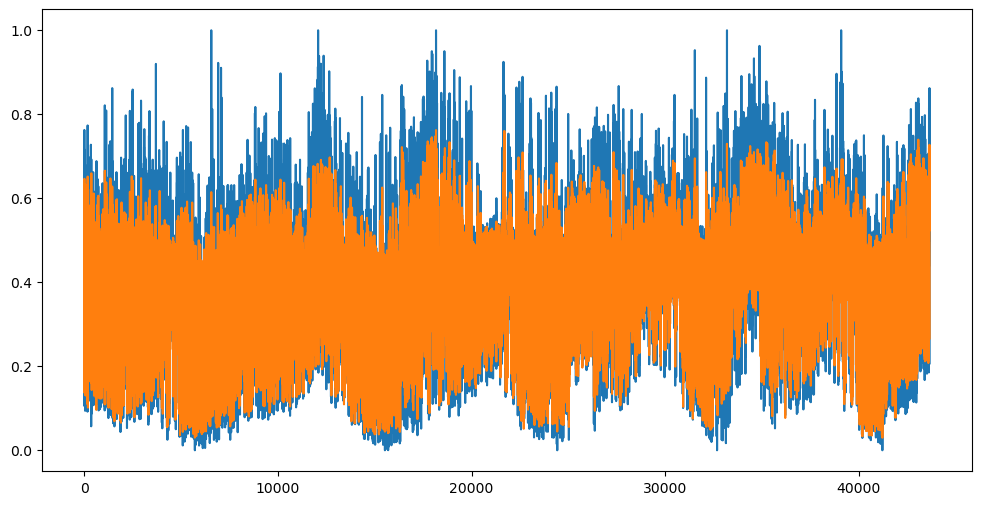

In [75]:
# plot a time series of the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y.values, label='actual')
plt.plot(Y_preds, label='predicted')

In [41]:
Y_dists.params['loc'][:100]

array([0.53983824, 0.47007979, 0.45409036, 0.43198391, 0.40230485,
       0.36534566, 0.33679272, 0.32311408, 0.28780497, 0.30197518,
       0.42644791, 0.45389205, 0.44640247, 0.46600577, 0.47416625,
       0.51320806, 0.60465916, 0.62019856, 0.52081112, 0.46693096,
       0.46337479, 0.4676796 , 0.4701975 , 0.45871999, 0.46363701,
       0.49367782, 0.44357286, 0.44553757, 0.40004082, 0.3880878 ,
       0.35688555, 0.33805646, 0.37759501, 0.4024792 , 0.40954179,
       0.41086605, 0.43937713, 0.44572795, 0.47080628, 0.63704322,
       0.59215253, 0.5711273 , 0.5373814 , 0.4648122 , 0.45991248,
       0.45144255, 0.45573701, 0.46880847, 0.57559266, 0.49574592,
       0.42942132, 0.4045428 , 0.36795334, 0.3632649 , 0.36542246,
       0.36523821, 0.33640428, 0.33311003, 0.40249991, 0.43881491,
       0.43069024, 0.49039042, 0.47336214, 0.49795193, 0.62072838,
       0.56534925, 0.55783047, 0.46271176, 0.46117676, 0.46025479,
       0.49564352, 0.48353395, 0.51257838, 0.49836509, 0.49342

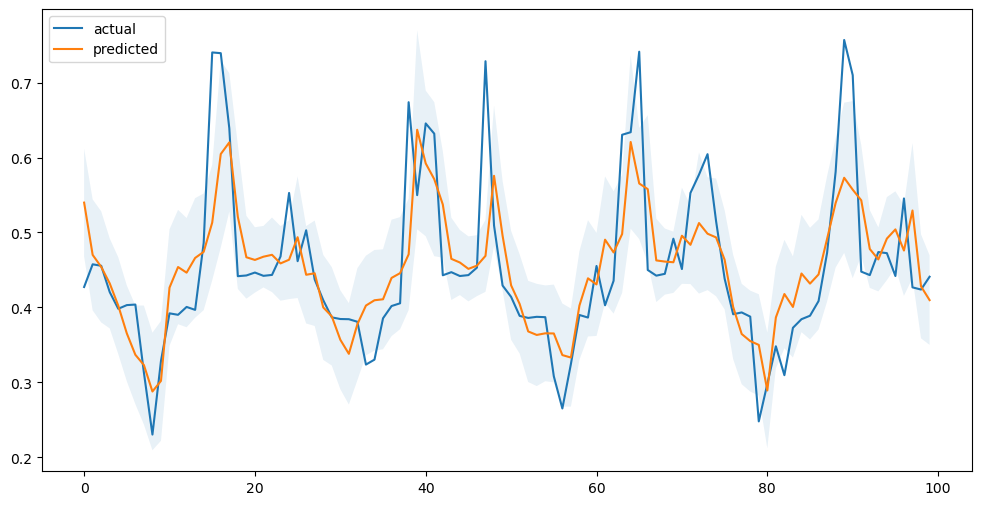

In [42]:
# plot first 100 predicted vs actual values with distributions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='actual')
plt.plot(Y_preds[:100], label='predicted')
plt.fill_between(np.arange(100), Y_dists.params['loc'][:100] - Y_dists.params['scale'][:100],
                    Y_dists.params['loc'][:100] + Y_dists.params['scale'][:100], alpha=0.1)
plt.legend()

In [56]:
evals_result = {}
sampler = TPESampler(seed = 123)

def objective(trial):
    params = {
        'Dist': Normal,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'minibatch_frac': trial.suggest_uniform('minibatch_frac', 0.1, 1.0),
        'col_sample': trial.suggest_uniform('col_sample', 0.1, 1.0),
    }
        
    # 6-fold time-series cross validation
    tfold = GroupTimeSeriesSplit()
    logl_list = []
    for _, (train_index, test_index) in tqdm(enumerate(tfold.split(X_temp, y, groups))):
        X_train = X_temp.iloc[train_index]
        X_val = X_temp.iloc[test_index]
        y_train = y[train_index]
        y_val = y[test_index]        
        # train ngboost model
        model = NGBRegressor(**params).fit(X_train, y_train)
        # calculate negative log likelihood
        Y_dists = model.pred_dist(X_val)
        loss = -Y_dists.logpdf(y_val).mean()
    logl_list.append(loss)
    trial.set_user_attr(key="best_booster", value=model)
    print(f'\n average loss: {np.mean(logl_list)}')
    return np.mean(logl_list)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

In [57]:
study_model = optuna.create_study(direction = 'minimize', sampler = sampler)
study_model.optimize(objective, n_trials = 50, callbacks=[callback])
best_model=study_model.user_attrs["best_booster"]

[I 2023-09-07 22:28:09,753] A new study created in memory with name: no-name-d7d37a13-8c40-4894-aa30-35f6fdfc7a92
0it [00:00, ?it/s]

[iter 0] loss=-0.5223 val_loss=0.0000 scale=1.0000 norm=0.5873


1it [00:01,  1.81s/it]

[iter 0] loss=-0.6026 val_loss=0.0000 scale=1.0000 norm=0.6116


2it [00:05,  2.70s/it]

[iter 0] loss=-0.6165 val_loss=0.0000 scale=1.0000 norm=0.5806


3it [00:10,  3.83s/it]

[iter 0] loss=-0.5882 val_loss=0.0000 scale=1.0000 norm=0.5860


4it [00:17,  5.26s/it]

[iter 0] loss=-0.5551 val_loss=0.0000 scale=1.0000 norm=0.5822


5it [00:28,  5.70s/it]
[I 2023-09-07 22:28:38,279] Trial 0 finished with value: -1.1354616705119531 and parameters: {'learning_rate': 0.02471373418487883, 'minibatch_frac': 0.3575254014553415, 'col_sample': 0.3041663082077828}. Best is trial 0 with value: -1.1354616705119531.



 average loss: -1.1354616705119531


0it [00:00, ?it/s]

[iter 0] loss=-0.5069 val_loss=0.0000 scale=1.0000 norm=0.5928


1it [00:04,  4.51s/it]

[iter 0] loss=-0.5965 val_loss=0.0000 scale=1.0000 norm=0.6106


2it [00:13,  7.03s/it]

[iter 0] loss=-0.6072 val_loss=0.0000 scale=1.0000 norm=0.5921


3it [00:26,  9.93s/it]

[iter 0] loss=-0.5885 val_loss=0.0000 scale=1.0000 norm=0.5856


4it [00:44, 12.92s/it]

[iter 0] loss=-0.5578 val_loss=0.0000 scale=1.0000 norm=0.5823


5it [01:07, 13.58s/it]
[I 2023-09-07 22:29:46,244] Trial 1 finished with value: -1.069442555907473 and parameters: {'learning_rate': 0.012665709946616687, 'minibatch_frac': 0.7475220728070068, 'col_sample': 0.4807958141120149}. Best is trial 0 with value: -1.1354616705119531.



 average loss: -1.069442555907473


0it [00:00, ?it/s]

[iter 0] loss=-0.5116 val_loss=0.0000 scale=1.0000 norm=0.5951


1it [00:05,  5.27s/it]

[iter 0] loss=-0.5999 val_loss=0.0000 scale=1.0000 norm=0.6085


2it [00:16,  9.00s/it]

[iter 0] loss=-0.6118 val_loss=0.0000 scale=1.0000 norm=0.5895


3it [00:30, 11.09s/it]

[iter 0] loss=-0.5856 val_loss=0.0000 scale=1.0000 norm=0.5870


4it [00:49, 14.08s/it]

[iter 0] loss=-0.5509 val_loss=0.0000 scale=1.0000 norm=0.5879


5it [01:12, 14.54s/it]
[I 2023-09-07 22:30:58,994] Trial 2 finished with value: -1.084417891390032 and parameters: {'learning_rate': 0.09152261002780922, 'minibatch_frac': 0.7163467647263769, 'col_sample': 0.5328387113359249}. Best is trial 0 with value: -1.1354616705119531.



 average loss: -1.084417891390032


0it [00:00, ?it/s]

[iter 0] loss=-0.5112 val_loss=0.0000 scale=1.0000 norm=0.5887


1it [00:03,  3.88s/it]

[iter 0] loss=-0.6101 val_loss=0.0000 scale=1.0000 norm=0.5989


2it [00:11,  5.95s/it]

[iter 0] loss=-0.6155 val_loss=0.0000 scale=1.0000 norm=0.5845


3it [00:22,  8.43s/it]

[iter 0] loss=-0.5853 val_loss=0.0000 scale=1.0000 norm=0.5857


4it [00:37, 11.14s/it]

[iter 0] loss=-0.5573 val_loss=0.0000 scale=1.0000 norm=0.5834


5it [00:58, 11.62s/it]
[I 2023-09-07 22:31:57,137] Trial 3 finished with value: -0.875669739569741 and parameters: {'learning_rate': 0.006084642077147054, 'minibatch_frac': 0.4088602145357825, 'col_sample': 0.7561447366456374}. Best is trial 0 with value: -1.1354616705119531.



 average loss: -0.875669739569741


0it [00:00, ?it/s]

[iter 0] loss=-0.5216 val_loss=0.0000 scale=1.0000 norm=0.5842


1it [00:01,  1.43s/it]

[iter 0] loss=-0.5940 val_loss=0.0000 scale=1.0000 norm=0.6120


2it [00:04,  2.18s/it]

[iter 0] loss=-0.5818 val_loss=0.0000 scale=1.0000 norm=0.6097


3it [00:08,  3.20s/it]

[iter 0] loss=-0.5829 val_loss=0.0000 scale=1.0000 norm=0.5918


4it [00:15,  4.50s/it]

[iter 0] loss=-0.5576 val_loss=0.0000 scale=1.0000 norm=0.5803


5it [00:23,  4.78s/it]
[I 2023-09-07 22:32:21,053] Trial 4 finished with value: -0.8952199502849197 and parameters: {'learning_rate': 0.007536062461086747, 'minibatch_frac': 0.15371010694861154, 'col_sample': 0.4582398297973883}. Best is trial 0 with value: -1.1354616705119531.



 average loss: -0.8952199502849197


0it [00:00, ?it/s]

[iter 0] loss=-0.5404 val_loss=0.0000 scale=1.0000 norm=0.5767


1it [00:01,  1.39s/it]

[iter 0] loss=-0.5963 val_loss=0.0000 scale=1.0000 norm=0.6058


2it [00:04,  2.12s/it]

[iter 0] loss=-0.6134 val_loss=0.0000 scale=1.0000 norm=0.5921


3it [00:08,  3.01s/it]

[iter 0] loss=-0.5739 val_loss=0.0000 scale=1.0000 norm=0.5962


4it [00:14,  4.18s/it]

[iter 0] loss=-0.5623 val_loss=0.0000 scale=1.0000 norm=0.5829


5it [00:22,  4.47s/it]
[I 2023-09-07 22:32:43,456] Trial 5 finished with value: -1.1417396031627811 and parameters: {'learning_rate': 0.029922013287804083, 'minibatch_frac': 0.26424255740815, 'col_sample': 0.2579065805327433}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1417396031627811


0it [00:00, ?it/s]

[iter 0] loss=-0.5126 val_loss=0.0000 scale=1.0000 norm=0.5887


1it [00:04,  4.58s/it]

[iter 0] loss=-0.5922 val_loss=0.0000 scale=1.0000 norm=0.6137


2it [00:13,  7.18s/it]

[iter 0] loss=-0.6140 val_loss=0.0000 scale=1.0000 norm=0.5832


3it [00:27, 10.08s/it]

[iter 0] loss=-0.5842 val_loss=0.0000 scale=1.0000 norm=0.5870


4it [00:46, 13.92s/it]

[iter 0] loss=-0.5544 val_loss=0.0000 scale=1.0000 norm=0.5834


5it [01:10, 14.18s/it]
[I 2023-09-07 22:33:54,394] Trial 6 finished with value: -1.0608839274178214 and parameters: {'learning_rate': 0.011563857936940024, 'minibatch_frac': 0.5786448283871795, 'col_sample': 0.6709608626961889}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.0608839274178214


0it [00:00, ?it/s]

[iter 0] loss=-0.5105 val_loss=0.0000 scale=1.0000 norm=0.5900


1it [00:05,  5.61s/it]

[iter 0] loss=-0.5992 val_loss=0.0000 scale=1.0000 norm=0.6095


2it [00:17,  9.11s/it]

[iter 0] loss=-0.6081 val_loss=0.0000 scale=1.0000 norm=0.5895


3it [00:33, 12.34s/it]

[iter 0] loss=-0.5879 val_loss=0.0000 scale=1.0000 norm=0.5861


4it [00:55, 16.32s/it]

[iter 0] loss=-0.5538 val_loss=0.0000 scale=1.0000 norm=0.5857


5it [01:25, 17.20s/it]
[I 2023-09-07 22:35:20,441] Trial 7 finished with value: -1.1185403478974332 and parameters: {'learning_rate': 0.04998774988536159, 'minibatch_frac': 0.7520097923745717, 'col_sample': 0.6499211596098246}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1185403478974332


0it [00:00, ?it/s]

[iter 0] loss=-0.5029 val_loss=0.0000 scale=1.0000 norm=0.5937


1it [00:02,  2.43s/it]

[iter 0] loss=-0.6146 val_loss=0.0000 scale=1.0000 norm=0.6004


2it [00:06,  3.66s/it]

[iter 0] loss=-0.6055 val_loss=0.0000 scale=1.0000 norm=0.5899


3it [00:13,  5.17s/it]

[iter 0] loss=-0.5875 val_loss=0.0000 scale=1.0000 norm=0.5860


4it [00:23,  7.00s/it]

[iter 0] loss=-0.5509 val_loss=0.0000 scale=1.0000 norm=0.5906


5it [00:36,  7.37s/it]
[I 2023-09-07 22:35:57,324] Trial 8 finished with value: -1.1301729325541474 and parameters: {'learning_rate': 0.02785394829873094, 'minibatch_frac': 0.39066302246786044, 'col_sample': 0.4256097900600827}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1301729325541474


0it [00:00, ?it/s]

[iter 0] loss=-0.5208 val_loss=0.0000 scale=1.0000 norm=0.5787


1it [00:03,  3.24s/it]

[iter 0] loss=-0.5986 val_loss=0.0000 scale=1.0000 norm=0.6100


2it [00:09,  5.08s/it]

[iter 0] loss=-0.6053 val_loss=0.0000 scale=1.0000 norm=0.5891


3it [00:19,  7.09s/it]

[iter 0] loss=-0.5814 val_loss=0.0000 scale=1.0000 norm=0.5930


4it [00:32,  9.54s/it]

[iter 0] loss=-0.5456 val_loss=0.0000 scale=1.0000 norm=0.5933


5it [00:49,  9.96s/it]
[I 2023-09-07 22:36:47,165] Trial 9 finished with value: -0.6715703795090908 and parameters: {'learning_rate': 0.0028610566807854877, 'minibatch_frac': 0.36434264174994646, 'col_sample': 0.667878511469039}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -0.6715703795090908


0it [00:00, ?it/s]

[iter 0] loss=-0.5157 val_loss=0.0000 scale=1.0000 norm=0.5880


1it [00:02,  2.32s/it]

[iter 0] loss=-0.6006 val_loss=0.0000 scale=1.0000 norm=0.6092


2it [00:06,  3.56s/it]

[iter 0] loss=-0.6077 val_loss=0.0000 scale=1.0000 norm=0.5899


3it [00:13,  4.97s/it]

[iter 0] loss=-0.5849 val_loss=0.0000 scale=1.0000 norm=0.5879


4it [00:22,  6.69s/it]

[iter 0] loss=-0.5566 val_loss=0.0000 scale=1.0000 norm=0.5842


5it [00:35,  7.07s/it]
[I 2023-09-07 22:37:22,562] Trial 10 finished with value: -0.5488242108335403 and parameters: {'learning_rate': 0.001569671210725707, 'minibatch_frac': 0.9583095033596778, 'col_sample': 0.14586606216253234}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -0.5488242108335403


0it [00:00, ?it/s]

[iter 0] loss=-0.5641 val_loss=0.0000 scale=1.0000 norm=0.5644


1it [00:01,  1.58s/it]

[iter 0] loss=-0.5983 val_loss=0.0000 scale=1.0000 norm=0.6135


2it [00:03,  1.74s/it]

[iter 0] loss=-0.6316 val_loss=0.0000 scale=1.0000 norm=0.5743


3it [00:06,  2.30s/it]

[iter 0] loss=-0.5852 val_loss=0.0000 scale=1.0000 norm=0.5904


4it [00:10,  3.17s/it]

[iter 0] loss=-0.5469 val_loss=0.0000 scale=1.0000 norm=0.5860


5it [00:17,  3.45s/it]
[I 2023-09-07 22:37:39,867] Trial 11 finished with value: -1.127485696826073 and parameters: {'learning_rate': 0.026370634050048934, 'minibatch_frac': 0.12352233241864835, 'col_sample': 0.2111246679459916}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.127485696826073


0it [00:00, ?it/s]

[iter 0] loss=-0.4995 val_loss=0.0000 scale=1.0000 norm=0.5997


1it [00:03,  3.43s/it]

[iter 0] loss=-0.6195 val_loss=0.0000 scale=1.0000 norm=0.5992


2it [00:10,  5.44s/it]

[iter 0] loss=-0.6080 val_loss=0.0000 scale=1.0000 norm=0.5948


3it [00:20,  7.48s/it]

[iter 0] loss=-0.5875 val_loss=0.0000 scale=1.0000 norm=0.5820


4it [00:34, 10.13s/it]

[iter 0] loss=-0.5533 val_loss=0.0000 scale=1.0000 norm=0.5882


5it [00:52, 10.50s/it]
[I 2023-09-07 22:38:32,417] Trial 12 finished with value: -1.1257937090968826 and parameters: {'learning_rate': 0.02434204875372115, 'minibatch_frac': 0.2605263559124284, 'col_sample': 0.9876601507615161}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1257937090968826


0it [00:00, ?it/s]

[iter 0] loss=-0.5247 val_loss=0.0000 scale=1.0000 norm=0.5842


1it [00:02,  2.33s/it]

[iter 0] loss=-0.5991 val_loss=0.0000 scale=1.0000 norm=0.6095


2it [00:06,  3.57s/it]

[iter 0] loss=-0.6181 val_loss=0.0000 scale=1.0000 norm=0.5830


3it [00:13,  5.18s/it]

[iter 0] loss=-0.5978 val_loss=0.0000 scale=1.0000 norm=0.5814


4it [00:23,  6.91s/it]

[iter 0] loss=-0.5527 val_loss=0.0000 scale=1.0000 norm=0.5865


5it [00:36,  7.32s/it]
[I 2023-09-07 22:39:09,052] Trial 13 finished with value: -1.123540818834848 and parameters: {'learning_rate': 0.061143595500708706, 'minibatch_frac': 0.5308017691477184, 'col_sample': 0.2973844145586381}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.123540818834848


0it [00:00, ?it/s]

[iter 0] loss=-0.5166 val_loss=0.0000 scale=1.0000 norm=0.5898


1it [00:01,  1.54s/it]

[iter 0] loss=-0.6111 val_loss=0.0000 scale=1.0000 norm=0.6011


2it [00:04,  2.35s/it]

[iter 0] loss=-0.6093 val_loss=0.0000 scale=1.0000 norm=0.5895


3it [00:09,  3.36s/it]

[iter 0] loss=-0.5820 val_loss=0.0000 scale=1.0000 norm=0.5900


4it [00:15,  4.65s/it]

[iter 0] loss=-0.5605 val_loss=0.0000 scale=1.0000 norm=0.5775


5it [00:24,  4.94s/it]
[I 2023-09-07 22:39:33,816] Trial 14 finished with value: -1.1168399239887845 and parameters: {'learning_rate': 0.01747005269753773, 'minibatch_frac': 0.27155923194507703, 'col_sample': 0.2955543457660051}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1168399239887845


0it [00:00, ?it/s]

[iter 0] loss=-0.4978 val_loss=0.0000 scale=1.0000 norm=0.5936


1it [00:01,  1.53s/it]

[iter 0] loss=-0.5955 val_loss=0.0000 scale=1.0000 norm=0.6129


2it [00:04,  2.28s/it]

[iter 0] loss=-0.6209 val_loss=0.0000 scale=1.0000 norm=0.5793


3it [00:08,  3.31s/it]

[iter 0] loss=-0.5966 val_loss=0.0000 scale=1.0000 norm=0.5798


4it [00:15,  4.68s/it]

[iter 0] loss=-0.5588 val_loss=0.0000 scale=1.0000 norm=0.5818


5it [00:24,  4.93s/it]
[I 2023-09-07 22:39:58,512] Trial 15 finished with value: -1.114652461135575 and parameters: {'learning_rate': 0.0452260955969372, 'minibatch_frac': 0.24775361775252233, 'col_sample': 0.3228057521310409}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.114652461135575


0it [00:00, ?it/s]

[iter 0] loss=-0.5023 val_loss=0.0000 scale=1.0000 norm=0.5983


1it [00:01,  1.24s/it]

[iter 0] loss=-0.5813 val_loss=0.0000 scale=1.0000 norm=0.6207


2it [00:03,  1.86s/it]

[iter 0] loss=-0.5976 val_loss=0.0000 scale=1.0000 norm=0.5988


3it [00:07,  2.68s/it]

[iter 0] loss=-0.5845 val_loss=0.0000 scale=1.0000 norm=0.5869


4it [00:12,  3.79s/it]

[iter 0] loss=-0.5546 val_loss=0.0000 scale=1.0000 norm=0.5866


5it [00:20,  4.04s/it]
[I 2023-09-07 22:40:18,750] Trial 16 finished with value: -0.6875931439109347 and parameters: {'learning_rate': 0.004667033354991915, 'minibatch_frac': 0.462800274850985, 'col_sample': 0.10227198393952319}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -0.6875931439109347


0it [00:00, ?it/s]

[iter 0] loss=-0.5234 val_loss=0.0000 scale=1.0000 norm=0.5872


1it [00:01,  1.38s/it]

[iter 0] loss=-0.5886 val_loss=0.0000 scale=1.0000 norm=0.6187


2it [00:03,  2.04s/it]

[iter 0] loss=-0.6079 val_loss=0.0000 scale=1.0000 norm=0.5894


3it [00:07,  2.92s/it]

[iter 0] loss=-0.5893 val_loss=0.0000 scale=1.0000 norm=0.5841


4it [00:13,  4.02s/it]

[iter 0] loss=-0.5630 val_loss=0.0000 scale=1.0000 norm=0.5784


5it [00:21,  4.33s/it]
[I 2023-09-07 22:40:40,426] Trial 17 finished with value: -1.121222047787667 and parameters: {'learning_rate': 0.03680354457759729, 'minibatch_frac': 0.30399869607346613, 'col_sample': 0.20604304264726928}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.121222047787667


0it [00:00, ?it/s]

[iter 0] loss=-0.5119 val_loss=0.0000 scale=1.0000 norm=0.5932


1it [00:02,  2.85s/it]

[iter 0] loss=-0.6034 val_loss=0.0000 scale=1.0000 norm=0.6042


2it [00:08,  4.31s/it]

[iter 0] loss=-0.6109 val_loss=0.0000 scale=1.0000 norm=0.5900


3it [00:16,  6.18s/it]

[iter 0] loss=-0.5818 val_loss=0.0000 scale=1.0000 norm=0.5914


4it [00:27,  8.23s/it]

[iter 0] loss=-0.5613 val_loss=0.0000 scale=1.0000 norm=0.5814


5it [00:43,  8.64s/it]
[I 2023-09-07 22:41:23,652] Trial 18 finished with value: -1.1154257306966748 and parameters: {'learning_rate': 0.09738271039461624, 'minibatch_frac': 0.6033030326766393, 'col_sample': 0.3466497008053269}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1154257306966748


0it [00:00, ?it/s]

[iter 0] loss=-0.5285 val_loss=0.0000 scale=1.0000 norm=0.5979


1it [00:01,  1.44s/it]

[iter 0] loss=-0.5765 val_loss=0.0000 scale=1.0000 norm=0.6270


2it [00:04,  2.19s/it]

[iter 0] loss=-0.6121 val_loss=0.0000 scale=1.0000 norm=0.5873


3it [00:08,  3.17s/it]

[iter 0] loss=-0.5800 val_loss=0.0000 scale=1.0000 norm=0.5849


4it [00:14,  4.40s/it]

[iter 0] loss=-0.5543 val_loss=0.0000 scale=1.0000 norm=0.5861


5it [00:23,  4.74s/it]
[I 2023-09-07 22:41:47,385] Trial 19 finished with value: -1.1028079050666408 and parameters: {'learning_rate': 0.016018246587447046, 'minibatch_frac': 0.18478277873535237, 'col_sample': 0.40050174340663874}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1028079050666408


0it [00:00, ?it/s]

[iter 0] loss=-0.5178 val_loss=0.0000 scale=1.0000 norm=0.5866


1it [00:02,  2.95s/it]

[iter 0] loss=-0.5989 val_loss=0.0000 scale=1.0000 norm=0.6096


2it [00:08,  4.61s/it]

[iter 0] loss=-0.6084 val_loss=0.0000 scale=1.0000 norm=0.5896


3it [00:17,  6.47s/it]

[iter 0] loss=-0.5845 val_loss=0.0000 scale=1.0000 norm=0.5882


4it [00:29,  8.64s/it]

[iter 0] loss=-0.5570 val_loss=0.0000 scale=1.0000 norm=0.5836


5it [00:45,  9.02s/it]
[I 2023-09-07 22:42:32,525] Trial 20 finished with value: -0.6619551042048138 and parameters: {'learning_rate': 0.003475777948812085, 'minibatch_frac': 0.979312293294266, 'col_sample': 0.22064094790353084}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -0.6619551042048138


0it [00:00, ?it/s]

[iter 0] loss=-0.4962 val_loss=0.0000 scale=1.0000 norm=0.6016


1it [00:02,  2.83s/it]

[iter 0] loss=-0.5955 val_loss=0.0000 scale=1.0000 norm=0.6091


2it [00:07,  3.69s/it]

[iter 0] loss=-0.5982 val_loss=0.0000 scale=1.0000 norm=0.6011


3it [00:13,  5.08s/it]

[iter 0] loss=-0.5865 val_loss=0.0000 scale=1.0000 norm=0.5877


4it [00:23,  6.80s/it]

[iter 0] loss=-0.5663 val_loss=0.0000 scale=1.0000 norm=0.5774


5it [00:35,  7.19s/it]
[I 2023-09-07 22:43:08,525] Trial 21 finished with value: -1.1355114232017378 and parameters: {'learning_rate': 0.02461494573229242, 'minibatch_frac': 0.38866022982425225, 'col_sample': 0.3862946049666018}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1355114232017378


0it [00:00, ?it/s]

[iter 0] loss=-0.5116 val_loss=0.0000 scale=1.0000 norm=0.5895


1it [00:02,  2.64s/it]

[iter 0] loss=-0.6076 val_loss=0.0000 scale=1.0000 norm=0.6043


2it [00:07,  4.01s/it]

[iter 0] loss=-0.6102 val_loss=0.0000 scale=1.0000 norm=0.5848


3it [00:15,  5.66s/it]

[iter 0] loss=-0.5887 val_loss=0.0000 scale=1.0000 norm=0.5881


4it [00:25,  7.62s/it]

[iter 0] loss=-0.5513 val_loss=0.0000 scale=1.0000 norm=0.5874


5it [00:40,  8.19s/it]
[I 2023-09-07 22:43:49,492] Trial 22 finished with value: -1.1315207423129705 and parameters: {'learning_rate': 0.018122130764478068, 'minibatch_frac': 0.503457913124854, 'col_sample': 0.3730922105521475}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1315207423129705


0it [00:00, ?it/s]

[iter 0] loss=-0.5120 val_loss=0.0000 scale=1.0000 norm=0.5934


1it [00:01,  1.61s/it]

[iter 0] loss=-0.6034 val_loss=0.0000 scale=1.0000 norm=0.6080


2it [00:04,  2.41s/it]

[iter 0] loss=-0.6029 val_loss=0.0000 scale=1.0000 norm=0.5923


3it [00:14,  5.87s/it]

[iter 0] loss=-0.5769 val_loss=0.0000 scale=1.0000 norm=0.5907


4it [00:22,  6.58s/it]

[iter 0] loss=-0.5456 val_loss=0.0000 scale=1.0000 norm=0.5931


5it [00:32,  6.49s/it]
[I 2023-09-07 22:44:22,010] Trial 23 finished with value: -1.1410571671252978 and parameters: {'learning_rate': 0.03421839187506414, 'minibatch_frac': 0.358927435234147, 'col_sample': 0.2433743298087921}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1410571671252978


0it [00:00, ?it/s]

[iter 0] loss=-0.5244 val_loss=0.0000 scale=1.0000 norm=0.5824


1it [00:02,  2.22s/it]

[iter 0] loss=-0.5864 val_loss=0.0000 scale=1.0000 norm=0.6174


2it [00:05,  2.95s/it]

[iter 0] loss=-0.6089 val_loss=0.0000 scale=1.0000 norm=0.5899


3it [00:10,  3.87s/it]

[iter 0] loss=-0.5988 val_loss=0.0000 scale=1.0000 norm=0.5813


4it [00:17,  5.13s/it]

[iter 0] loss=-0.5519 val_loss=0.0000 scale=1.0000 norm=0.5893


5it [00:27,  5.53s/it]
[I 2023-09-07 22:44:49,709] Trial 24 finished with value: -1.116989955332547 and parameters: {'learning_rate': 0.059245386090704115, 'minibatch_frac': 0.4446597171187142, 'col_sample': 0.1986437657025084}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.116989955332547


0it [00:00, ?it/s]

[iter 0] loss=-0.5426 val_loss=0.0000 scale=1.0000 norm=0.5906


1it [00:01,  1.99s/it]

[iter 0] loss=-0.5949 val_loss=0.0000 scale=1.0000 norm=0.6105


2it [00:06,  3.28s/it]

[iter 0] loss=-0.6042 val_loss=0.0000 scale=1.0000 norm=0.5847


3it [00:12,  4.89s/it]

[iter 0] loss=-0.5765 val_loss=0.0000 scale=1.0000 norm=0.5889


4it [00:22,  6.52s/it]

[iter 0] loss=-0.5738 val_loss=0.0000 scale=1.0000 norm=0.5769


5it [00:34,  6.84s/it]
[I 2023-09-07 22:45:23,961] Trial 25 finished with value: -1.127410564588491 and parameters: {'learning_rate': 0.03516029651092831, 'minibatch_frac': 0.20336992017856656, 'col_sample': 0.564498295576148}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.127410564588491


0it [00:00, ?it/s]

[iter 0] loss=-0.5161 val_loss=0.0000 scale=1.0000 norm=0.5868


1it [00:01,  1.39s/it]

[iter 0] loss=-0.6041 val_loss=0.0000 scale=1.0000 norm=0.6015


2it [00:03,  2.04s/it]

[iter 0] loss=-0.6081 val_loss=0.0000 scale=1.0000 norm=0.5885


3it [00:07,  2.55s/it]

[iter 0] loss=-0.5782 val_loss=0.0000 scale=1.0000 norm=0.5911


4it [00:12,  3.60s/it]

[iter 0] loss=-0.5464 val_loss=0.0000 scale=1.0000 norm=0.5896


5it [00:19,  3.86s/it]
[I 2023-09-07 22:45:43,324] Trial 26 finished with value: -0.8220558312689893 and parameters: {'learning_rate': 0.008750380079673282, 'minibatch_frac': 0.30786331539935236, 'col_sample': 0.10529416500106331}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -0.8220558312689893


0it [00:00, ?it/s]

[iter 0] loss=-0.5038 val_loss=0.0000 scale=1.0000 norm=0.5975


1it [00:02,  2.28s/it]

[iter 0] loss=-0.5974 val_loss=0.0000 scale=1.0000 norm=0.6131


2it [00:06,  3.36s/it]

[iter 0] loss=-0.6112 val_loss=0.0000 scale=1.0000 norm=0.5860


3it [00:13,  4.89s/it]

[iter 0] loss=-0.5852 val_loss=0.0000 scale=1.0000 norm=0.5872


4it [00:29,  9.45s/it]

[iter 0] loss=-0.5543 val_loss=0.0000 scale=1.0000 norm=0.5863


5it [00:42,  8.55s/it]
[I 2023-09-07 22:46:26,123] Trial 27 finished with value: -1.1201772441237428 and parameters: {'learning_rate': 0.07429988854846167, 'minibatch_frac': 0.6437867097289982, 'col_sample': 0.22851633373449304}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1201772441237428


0it [00:00, ?it/s]

[iter 0] loss=-0.4729 val_loss=0.0000 scale=1.0000 norm=0.6202


1it [00:01,  1.29s/it]

[iter 0] loss=-0.5868 val_loss=0.0000 scale=1.0000 norm=0.6148


2it [00:03,  1.94s/it]

[iter 0] loss=-0.6322 val_loss=0.0000 scale=1.0000 norm=0.5789


3it [00:07,  2.78s/it]

[iter 0] loss=-0.5767 val_loss=0.0000 scale=1.0000 norm=0.5964


4it [00:13,  3.98s/it]

[iter 0] loss=-0.5634 val_loss=0.0000 scale=1.0000 norm=0.5798


5it [00:21,  4.25s/it]
[I 2023-09-07 22:46:47,428] Trial 28 finished with value: -1.1159718794978395 and parameters: {'learning_rate': 0.035678446490765396, 'minibatch_frac': 0.10669993192256821, 'col_sample': 0.4891663409439587}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.1159718794978395


0it [00:00, ?it/s]

[iter 0] loss=-0.5090 val_loss=0.0000 scale=1.0000 norm=0.5940


1it [00:01,  1.64s/it]

[iter 0] loss=-0.6001 val_loss=0.0000 scale=1.0000 norm=0.6058


2it [00:04,  2.47s/it]

[iter 0] loss=-0.6090 val_loss=0.0000 scale=1.0000 norm=0.5895


3it [00:09,  3.56s/it]

[iter 0] loss=-0.5861 val_loss=0.0000 scale=1.0000 norm=0.5872


4it [00:16,  5.02s/it]

[iter 0] loss=-0.5591 val_loss=0.0000 scale=1.0000 norm=0.5790


5it [00:26,  5.29s/it]
[I 2023-09-07 22:47:13,901] Trial 29 finished with value: -1.127294528047125 and parameters: {'learning_rate': 0.020865279230287217, 'minibatch_frac': 0.3350528606271637, 'col_sample': 0.27586108919212887}. Best is trial 5 with value: -1.1417396031627811.



 average loss: -1.127294528047125


0it [00:00, ?it/s]

[iter 0] loss=-0.5212 val_loss=0.0000 scale=1.0000 norm=0.5846


1it [00:02,  2.49s/it]

[iter 0] loss=-0.6096 val_loss=0.0000 scale=1.0000 norm=0.6029


2it [00:07,  3.83s/it]

[iter 0] loss=-0.6104 val_loss=0.0000 scale=1.0000 norm=0.5883


3it [00:14,  5.44s/it]

[iter 0] loss=-0.5836 val_loss=0.0000 scale=1.0000 norm=0.5883


4it [00:25,  7.48s/it]

[iter 0] loss=-0.5565 val_loss=0.0000 scale=1.0000 norm=0.5855


5it [00:40,  8.08s/it]
[I 2023-09-07 22:47:54,354] Trial 30 finished with value: -1.1445235195220105 and parameters: {'learning_rate': 0.030896221748968562, 'minibatch_frac': 0.4582406967336896, 'col_sample': 0.3829756058866356}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1445235195220105


0it [00:00, ?it/s]

[iter 0] loss=-0.5084 val_loss=0.0000 scale=1.0000 norm=0.5905


1it [00:02,  2.64s/it]

[iter 0] loss=-0.6019 val_loss=0.0000 scale=1.0000 norm=0.6085


2it [00:07,  3.92s/it]

[iter 0] loss=-0.6060 val_loss=0.0000 scale=1.0000 norm=0.5898


3it [00:14,  5.47s/it]

[iter 0] loss=-0.5868 val_loss=0.0000 scale=1.0000 norm=0.5845


4it [00:24,  7.33s/it]

[iter 0] loss=-0.5598 val_loss=0.0000 scale=1.0000 norm=0.5825


5it [00:38,  7.76s/it]
[I 2023-09-07 22:48:33,260] Trial 31 finished with value: -1.0774981206317922 and parameters: {'learning_rate': 0.013874097624977448, 'minibatch_frac': 0.4513960312536296, 'col_sample': 0.3506746106493019}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.0774981206317922


0it [00:00, ?it/s]

[iter 0] loss=-0.4999 val_loss=0.0000 scale=1.0000 norm=0.5953


1it [00:03,  3.32s/it]

[iter 0] loss=-0.5902 val_loss=0.0000 scale=1.0000 norm=0.6156


2it [00:08,  4.19s/it]

[iter 0] loss=-0.6086 val_loss=0.0000 scale=1.0000 norm=0.5868


3it [00:15,  5.87s/it]

[iter 0] loss=-0.5798 val_loss=0.0000 scale=1.0000 norm=0.5915


4it [00:27,  8.20s/it]

[iter 0] loss=-0.5592 val_loss=0.0000 scale=1.0000 norm=0.5799


5it [00:43,  8.64s/it]
[I 2023-09-07 22:49:16,554] Trial 32 finished with value: -1.1358220347668604 and parameters: {'learning_rate': 0.029299190778602036, 'minibatch_frac': 0.3803385781247731, 'col_sample': 0.40180783021416105}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1358220347668604


0it [00:00, ?it/s]

[iter 0] loss=-0.5014 val_loss=0.0000 scale=1.0000 norm=0.5925


1it [00:02,  2.08s/it]

[iter 0] loss=-0.5935 val_loss=0.0000 scale=1.0000 norm=0.6099


2it [00:05,  2.76s/it]

[iter 0] loss=-0.6138 val_loss=0.0000 scale=1.0000 norm=0.5851


3it [00:11,  4.14s/it]

[iter 0] loss=-0.5830 val_loss=0.0000 scale=1.0000 norm=0.5875


4it [00:18,  5.35s/it]

[iter 0] loss=-0.5476 val_loss=0.0000 scale=1.0000 norm=0.5884


5it [00:29,  5.87s/it]
[I 2023-09-07 22:49:46,046] Trial 33 finished with value: -1.128528896623249 and parameters: {'learning_rate': 0.04340376063122192, 'minibatch_frac': 0.21308559897500068, 'col_sample': 0.26661692786548014}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.128528896623249


0it [00:00, ?it/s]

[iter 0] loss=-0.4951 val_loss=0.0000 scale=1.0000 norm=0.6008


1it [00:04,  4.06s/it]

[iter 0] loss=-0.5992 val_loss=0.0000 scale=1.0000 norm=0.6082


2it [00:13,  7.36s/it]

[iter 0] loss=-0.6093 val_loss=0.0000 scale=1.0000 norm=0.5875


3it [00:26,  9.85s/it]

[iter 0] loss=-0.5916 val_loss=0.0000 scale=1.0000 norm=0.5823


4it [00:43, 12.71s/it]

[iter 0] loss=-0.5545 val_loss=0.0000 scale=1.0000 norm=0.5855


5it [01:05, 13.09s/it]
[I 2023-09-07 22:50:51,627] Trial 34 finished with value: -1.1272431074150782 and parameters: {'learning_rate': 0.03336122342857961, 'minibatch_frac': 0.4883455788436548, 'col_sample': 0.506710342862136}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1272431074150782


0it [00:00, ?it/s]

[iter 0] loss=-0.5066 val_loss=0.0000 scale=1.0000 norm=0.5836


1it [00:03,  3.64s/it]

[iter 0] loss=-0.6223 val_loss=0.0000 scale=1.0000 norm=0.5948


2it [00:11,  6.06s/it]

[iter 0] loss=-0.6200 val_loss=0.0000 scale=1.0000 norm=0.5837


3it [00:22,  8.35s/it]

[iter 0] loss=-0.5963 val_loss=0.0000 scale=1.0000 norm=0.5822


4it [00:38, 11.53s/it]

[iter 0] loss=-0.5663 val_loss=0.0000 scale=1.0000 norm=0.5801


5it [00:59, 11.92s/it]
[I 2023-09-07 22:51:51,391] Trial 35 finished with value: -1.0810892474675213 and parameters: {'learning_rate': 0.0675134331874056, 'minibatch_frac': 0.3451848480144826, 'col_sample': 0.5690247746810797}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.0810892474675213


0it [00:00, ?it/s]

[iter 0] loss=-0.5338 val_loss=0.0000 scale=1.0000 norm=0.5862


1it [00:03,  3.39s/it]

[iter 0] loss=-0.6046 val_loss=0.0000 scale=1.0000 norm=0.6077


2it [00:08,  4.53s/it]

[iter 0] loss=-0.6105 val_loss=0.0000 scale=1.0000 norm=0.5853


3it [00:16,  5.88s/it]

[iter 0] loss=-0.5845 val_loss=0.0000 scale=1.0000 norm=0.5896


4it [00:27,  8.01s/it]

[iter 0] loss=-0.5580 val_loss=0.0000 scale=1.0000 norm=0.5841


5it [00:41,  8.29s/it]
[I 2023-09-07 22:52:32,916] Trial 36 finished with value: -1.1191180412891675 and parameters: {'learning_rate': 0.04919368417087457, 'minibatch_frac': 0.4249141238249163, 'col_sample': 0.4188811860191026}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1191180412891675


0it [00:00, ?it/s]

[iter 0] loss=-0.4993 val_loss=0.0000 scale=1.0000 norm=0.5962


1it [00:03,  3.37s/it]

[iter 0] loss=-0.6088 val_loss=0.0000 scale=1.0000 norm=0.6033


2it [00:09,  5.15s/it]

[iter 0] loss=-0.6096 val_loss=0.0000 scale=1.0000 norm=0.5898


3it [00:19,  7.35s/it]

[iter 0] loss=-0.5900 val_loss=0.0000 scale=1.0000 norm=0.5828


4it [00:33,  9.84s/it]

[iter 0] loss=-0.5578 val_loss=0.0000 scale=1.0000 norm=0.5835


5it [00:53, 10.68s/it]
[I 2023-09-07 22:53:26,405] Trial 37 finished with value: -1.0518428390749732 and parameters: {'learning_rate': 0.011839780039100021, 'minibatch_frac': 0.5559544398633751, 'col_sample': 0.4534140659148621}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.0518428390749732


0it [00:00, ?it/s]

[iter 0] loss=-0.4988 val_loss=0.0000 scale=1.0000 norm=0.5979


1it [00:02,  2.13s/it]

[iter 0] loss=-0.6054 val_loss=0.0000 scale=1.0000 norm=0.6046


2it [00:06,  3.36s/it]

[iter 0] loss=-0.6104 val_loss=0.0000 scale=1.0000 norm=0.5862


3it [00:12,  4.55s/it]

[iter 0] loss=-0.5816 val_loss=0.0000 scale=1.0000 norm=0.5926


4it [00:24,  7.47s/it]

[iter 0] loss=-0.5556 val_loss=0.0000 scale=1.0000 norm=0.5854


5it [00:34,  7.00s/it]
[I 2023-09-07 22:54:01,501] Trial 38 finished with value: -1.0942945617382098 and parameters: {'learning_rate': 0.020845415315145468, 'minibatch_frac': 0.6405380270864041, 'col_sample': 0.1590640803661436}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.0942945617382098


0it [00:00, ?it/s]

[iter 0] loss=-0.5118 val_loss=0.0000 scale=1.0000 norm=0.5910


1it [00:08,  8.66s/it]

[iter 0] loss=-0.6010 val_loss=0.0000 scale=1.0000 norm=0.6099


2it [00:25, 13.22s/it]

[iter 0] loss=-0.6037 val_loss=0.0000 scale=1.0000 norm=0.5928


3it [00:47, 17.62s/it]

[iter 0] loss=-0.5822 val_loss=0.0000 scale=1.0000 norm=0.5911


4it [01:19, 23.10s/it]

[iter 0] loss=-0.5555 val_loss=0.0000 scale=1.0000 norm=0.5851


5it [01:58, 23.75s/it]
[I 2023-09-07 22:56:00,413] Trial 39 finished with value: -1.0192237078977544 and parameters: {'learning_rate': 0.009841822699201155, 'minibatch_frac': 0.7900394376884982, 'col_sample': 0.9006234235846081}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.0192237078977544


0it [00:00, ?it/s]

[iter 0] loss=-0.5204 val_loss=0.0000 scale=1.0000 norm=0.5785


1it [00:01,  1.71s/it]

[iter 0] loss=-0.5952 val_loss=0.0000 scale=1.0000 norm=0.6135


2it [00:04,  2.60s/it]

[iter 0] loss=-0.5975 val_loss=0.0000 scale=1.0000 norm=0.5984


3it [00:09,  3.71s/it]

[iter 0] loss=-0.5805 val_loss=0.0000 scale=1.0000 norm=0.5911


4it [00:18,  5.48s/it]

[iter 0] loss=-0.5518 val_loss=0.0000 scale=1.0000 norm=0.5875


5it [00:28,  5.62s/it]
[I 2023-09-07 22:56:28,561] Trial 40 finished with value: -1.1075818515344003 and parameters: {'learning_rate': 0.08230367775747756, 'minibatch_frac': 0.39590181394686486, 'col_sample': 0.25438124489334224}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1075818515344003


0it [00:00, ?it/s]

[iter 0] loss=-0.4986 val_loss=0.0000 scale=1.0000 norm=0.5994


1it [00:02,  2.09s/it]

[iter 0] loss=-0.5961 val_loss=0.0000 scale=1.0000 norm=0.6149


2it [00:06,  3.20s/it]

[iter 0] loss=-0.6161 val_loss=0.0000 scale=1.0000 norm=0.5845


3it [00:12,  4.62s/it]

[iter 0] loss=-0.5893 val_loss=0.0000 scale=1.0000 norm=0.5830


4it [00:21,  6.24s/it]

[iter 0] loss=-0.5674 val_loss=0.0000 scale=1.0000 norm=0.5776


5it [00:33,  6.66s/it]
[I 2023-09-07 22:57:01,927] Trial 41 finished with value: -1.133618870954598 and parameters: {'learning_rate': 0.02776400334849391, 'minibatch_frac': 0.36914255690415254, 'col_sample': 0.3573822599299709}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.133618870954598


0it [00:00, ?it/s]

[iter 0] loss=-0.5206 val_loss=0.0000 scale=1.0000 norm=0.5846


1it [00:04,  4.70s/it]

[iter 0] loss=-0.6034 val_loss=0.0000 scale=1.0000 norm=0.6054


2it [00:08,  4.08s/it]

[iter 0] loss=-0.6059 val_loss=0.0000 scale=1.0000 norm=0.5893


3it [00:14,  4.82s/it]

[iter 0] loss=-0.5860 val_loss=0.0000 scale=1.0000 norm=0.5908


4it [00:22,  6.31s/it]

[iter 0] loss=-0.5594 val_loss=0.0000 scale=1.0000 norm=0.5814


5it [00:34,  6.94s/it]
[I 2023-09-07 22:57:36,742] Trial 42 finished with value: -1.1405990996634252 and parameters: {'learning_rate': 0.02248704387208328, 'minibatch_frac': 0.3055412680009566, 'col_sample': 0.40167834479030445}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1405990996634252


0it [00:00, ?it/s]

[iter 0] loss=-0.5183 val_loss=0.0000 scale=1.0000 norm=0.5956


1it [00:02,  2.05s/it]

[iter 0] loss=-0.6001 val_loss=0.0000 scale=1.0000 norm=0.6114


2it [00:05,  3.11s/it]

[iter 0] loss=-0.6190 val_loss=0.0000 scale=1.0000 norm=0.5821


3it [00:11,  4.45s/it]

[iter 0] loss=-0.5939 val_loss=0.0000 scale=1.0000 norm=0.5810


4it [00:20,  6.09s/it]

[iter 0] loss=-0.5679 val_loss=0.0000 scale=1.0000 norm=0.5768


5it [00:32,  6.41s/it]
[I 2023-09-07 22:58:08,889] Trial 43 finished with value: -1.0982651411465658 and parameters: {'learning_rate': 0.013837229558926944, 'minibatch_frac': 0.3040418778753089, 'col_sample': 0.4397568571071787}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.0982651411465658


0it [00:00, ?it/s]

[iter 0] loss=-0.5070 val_loss=0.0000 scale=1.0000 norm=0.5900


1it [00:02,  2.04s/it]

[iter 0] loss=-0.5924 val_loss=0.0000 scale=1.0000 norm=0.6152


2it [00:05,  3.16s/it]

[iter 0] loss=-0.6086 val_loss=0.0000 scale=1.0000 norm=0.5885


3it [00:12,  4.53s/it]

[iter 0] loss=-0.5890 val_loss=0.0000 scale=1.0000 norm=0.5799


4it [00:20,  6.18s/it]

[iter 0] loss=-0.5491 val_loss=0.0000 scale=1.0000 norm=0.5901


5it [00:32,  6.51s/it]
[I 2023-09-07 22:58:41,487] Trial 44 finished with value: -1.1227857377246064 and parameters: {'learning_rate': 0.031475747505050715, 'minibatch_frac': 0.2242514907138069, 'col_sample': 0.6072179344933486}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1227857377246064


0it [00:00, ?it/s]

[iter 0] loss=-0.5190 val_loss=0.0000 scale=1.0000 norm=0.5906


1it [00:01,  1.52s/it]

[iter 0] loss=-0.6081 val_loss=0.0000 scale=1.0000 norm=0.6002


2it [00:04,  2.38s/it]

[iter 0] loss=-0.6083 val_loss=0.0000 scale=1.0000 norm=0.5886


3it [00:09,  3.49s/it]

[iter 0] loss=-0.5968 val_loss=0.0000 scale=1.0000 norm=0.5826


4it [00:16,  4.77s/it]

[iter 0] loss=-0.5483 val_loss=0.0000 scale=1.0000 norm=0.5878


5it [00:25,  5.03s/it]
[I 2023-09-07 22:59:06,688] Trial 45 finished with value: -1.1375376318195405 and parameters: {'learning_rate': 0.041023526497614024, 'minibatch_frac': 0.27043659524589986, 'col_sample': 0.3127264641566863}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1375376318195405


0it [00:00, ?it/s]

[iter 0] loss=-0.5087 val_loss=0.0000 scale=1.0000 norm=0.5904


1it [00:00,  1.12it/s]

[iter 0] loss=-0.5854 val_loss=0.0000 scale=1.0000 norm=0.6187


2it [00:02,  1.35s/it]

[iter 0] loss=-0.5787 val_loss=0.0000 scale=1.0000 norm=0.6108


3it [00:05,  1.99s/it]

[iter 0] loss=-0.6034 val_loss=0.0000 scale=1.0000 norm=0.5732


4it [00:09,  2.88s/it]

[iter 0] loss=-0.5565 val_loss=0.0000 scale=1.0000 norm=0.5869


5it [00:15,  3.13s/it]
[I 2023-09-07 22:59:22,364] Trial 46 finished with value: -1.1058281855627143 and parameters: {'learning_rate': 0.04258456153473169, 'minibatch_frac': 0.15893986132968863, 'col_sample': 0.16192864641046434}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1058281855627143


0it [00:00, ?it/s]

[iter 0] loss=-0.5084 val_loss=0.0000 scale=1.0000 norm=0.5913


1it [00:01,  1.65s/it]

[iter 0] loss=-0.5965 val_loss=0.0000 scale=1.0000 norm=0.6103


2it [00:04,  2.51s/it]

[iter 0] loss=-0.6094 val_loss=0.0000 scale=1.0000 norm=0.5889


3it [00:09,  3.61s/it]

[iter 0] loss=-0.5871 val_loss=0.0000 scale=1.0000 norm=0.5859


4it [00:16,  4.96s/it]

[iter 0] loss=-0.5583 val_loss=0.0000 scale=1.0000 norm=0.5832


5it [00:26,  5.26s/it]
[I 2023-09-07 22:59:48,716] Trial 47 finished with value: -1.1168321389147355 and parameters: {'learning_rate': 0.053222281712114614, 'minibatch_frac': 0.3045213273789006, 'col_sample': 0.30974476375934323}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1168321389147355


0it [00:00, ?it/s]

[iter 0] loss=-0.5068 val_loss=0.0000 scale=1.0000 norm=0.5996


1it [00:01,  1.56s/it]

[iter 0] loss=-0.5812 val_loss=0.0000 scale=1.0000 norm=0.6193


2it [00:04,  2.34s/it]

[iter 0] loss=-0.6005 val_loss=0.0000 scale=1.0000 norm=0.5991


3it [00:08,  3.33s/it]

[iter 0] loss=-0.5802 val_loss=0.0000 scale=1.0000 norm=0.5890


4it [00:15,  4.63s/it]

[iter 0] loss=-0.5397 val_loss=0.0000 scale=1.0000 norm=0.5964


5it [00:25,  5.04s/it]
[I 2023-09-07 23:00:13,943] Trial 48 finished with value: -1.1302468107635861 and parameters: {'learning_rate': 0.021703228997424575, 'minibatch_frac': 0.2608421121966335, 'col_sample': 0.32284987470124277}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -1.1302468107635861


0it [00:00, ?it/s]

[iter 0] loss=-0.5102 val_loss=0.0000 scale=1.0000 norm=0.5844


1it [00:01,  1.89s/it]

[iter 0] loss=-0.6130 val_loss=0.0000 scale=1.0000 norm=0.6037


2it [00:05,  3.13s/it]

[iter 0] loss=-0.5885 val_loss=0.0000 scale=1.0000 norm=0.6051


3it [00:12,  4.56s/it]

[iter 0] loss=-0.5634 val_loss=0.0000 scale=1.0000 norm=0.6036


4it [00:20,  6.12s/it]

[iter 0] loss=-0.5520 val_loss=0.0000 scale=1.0000 norm=0.5908


5it [00:32,  6.48s/it]
[I 2023-09-07 23:00:46,369] Trial 49 finished with value: -0.8912515488711213 and parameters: {'learning_rate': 0.006649965908361763, 'minibatch_frac': 0.15618808541462773, 'col_sample': 0.7175219258125454}. Best is trial 30 with value: -1.1445235195220105.



 average loss: -0.8912515488711213


In [59]:
best_model.get_params()

{'Dist': ngboost.distns.normal.Normal,
 'Score': ngboost.scores.LogScore,
 'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3),
 'natural_gradient': True,
 'n_estimators': 100,
 'learning_rate': 0.030896221748968562,
 'minibatch_frac': 0.4582406967336896,
 'col_sample': 0.3829756058866356,
 'verbose': True,
 'random_state': RandomState(MT19937) at 0x14FE47C40}

In [66]:
# test best model
Y_preds = best_model.predict(X_temp)
Y_dists = best_model.pred_dist(X_temp)
# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, y_test)
print("Test MSE", test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(y_test).mean()
print("Test NLL", test_NLL)


ValueError: Found input variables with inconsistent numbers of samples: [43645, 8729]

In [60]:
joblib.dump(best_model, 'models/ngboost/ngboost_next_step.pkl')

['models/ngboost/ngboost_next_step.pkl']